# Read all the hap.py vcfs and compute overlaps

## Read metadata

In [3]:
import vcf
import vcf.utils
import glob
import re
import pandas as pd
import upsetplot
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
paths = glob.glob("d50_variant_analysis/*/*vcf.gz")

In [5]:
names, kits, concs, replicates = zip(*[
    re.match(r".*/(([A-Za-z0-9]+)-(\d+ng)-(\d))\.vcf\.gz", path).groups()
    for path in paths
])

## Data frame for metadata summary

In [6]:
df = pd.DataFrame({'Name': names, 'Kit': kits, 'Conc': concs, 'Replicate': replicates, 'Path': paths})

In [7]:
df.head()

,Name,Kit,Conc,Replicate,Path
0,NEB-10ng-1,NEB,10ng,1,d50_variant_analysis/NEB-10ng-1_happy/NEB-10ng...
1,NEB-10ng-3,NEB,10ng,3,d50_variant_analysis/NEB-10ng-3_happy/NEB-10ng...
2,Quanta-100ng-2,Quanta,100ng,2,d50_variant_analysis/Quanta-100ng-2_happy/Quan...
3,Swift2S-100ng-4,Swift2S,100ng,4,d50_variant_analysis/Swift2S-100ng-4_happy/Swi...
4,Nextera-10ng-3,Nextera,10ng,3,d50_variant_analysis/Nextera-10ng-3_happy/Next...


### Only analyse 100 ng data

In [8]:
# af = analysis data frame
af = df[(df.Conc=='100ng')&(df.Kit!="Swiftlong")]

In [9]:
kits = list(set(af.Kit))[::-1]
print(kits)

['Kapa', 'Quanta', 'Swift2S', 'NEB', 'Nextera']


## Open VCF files

VCF readers, and a list `kits_in_order` giving the kit for each of the readers.

In [10]:
kits_readers = [(row.Kit, vcf.Reader(filename=row.Path)) for _, row in af.iterrows()]
kits_in_order, readers = zip(*kits_readers)

## Make a place to hold the counts

`group_combinations`

| Truth | Type  | Value |
|-------|-------|-------|
| True  | SNP   | Series counts |
| False | SNP   | Series counts |
| True  | INDEL | Series counts |
| False | INDEL | Series counts |

Series counts are series containing the counts of each combination of callers. The indexes are MultiIndexes with one level for each kit, with value True if the variant is called, False otherwise.

In [9]:
group_counts_idx = pd.MultiIndex.from_product([[True,False] for _ in kits], names=kits)
types = ['SNP', 'INDEL'] # May need to refactor if we're to separate indel types
group_combinations = {
    (truth, typ): pd.Series(index=group_counts_idx, dtype='uint32')
    for typ in types
    for truth in [True, False]
    }
intra_kit_consensus = {kitname: [0, 0, 0, 0, 0] for kitname in kits}

## VCF Reading loop

In [10]:
abort = 200000
#abort = 200000000

for variants in vcf.utils.walk_together(*readers):
    if abort == 0:
        break
    else:
        abort -= 1
        if abort % 100000 == 0:
            print(abort, "variants remaining...")
            
    is_true = (variants[0] and variants[0].samples[0].data.BD == 'TP') == True
    
    typ = next(iter(
        vcall.samples[isam].data.BVT
        for vcall in variants
        for isam in [0,1]
        if vcall and vcall.samples[isam].data.BVT != 'NOCALL'
    ))
    
    var_group_counts = [0] * len(kits)
    for vcall, kit in zip(variants, kits_in_order):
        if vcall:
            if vcall.samples[1].data.BD == 'TP' and vcall.samples[1].data.QQ >= -5:
                var_group_counts[kits.index(kit)] += 1
    
    if is_true:
        for i, kit in enumerate(kits):
            intra_kit_consensus[kit][var_group_counts[i]] += 1
            
    combinations_index = tuple(x > 2 for x in var_group_counts)
    
    group_combinations[(is_true, typ)][combinations_index] += 1


100000 variants remaining...
0 variants remaining...


### Experimental colouring by true/false

In [26]:
# Make TP/FP in single data frame
group_data = {}
for typ in ['SNP', 'INDEL']:
    group_data[typ] = pd.concat([
        pd.DataFrame({'Count': group_combinations[(truth, 'SNP')]}).assign(Truth= truth)
        for truth in [True, False]
    ])

In [59]:
#upsetplot.plot(group_combinations.drop(tuple([0]*len(kits))).drop(tuple([1]*len(kits))), sort_by='cardinality')
up = upsetplot.UpSet(
    group_data['SNP'].drop(tuple([0]*len(kits))),
    sort_by='cardinality',
    sort_categories_by=None,
    sum_over='Count'
)

In [66]:
totales_orig_save = upsetplot.UpSet.plot_totals

In [ ]:
def plot_totals_mar(self, ax, hue):
    """Plot bars indicating total set size
    """
    orig_ax = ax
    ax = self._reorient(ax)
    recst = sns.barplot()
    rects = ax.barh(np.arange(len(self.totals.index.values)), self.totals,
                    .5, color=self._facecolor, align='center')
    self._label_sizes(ax, rects, 'left' if self._horizontal else 'top')

    max_total = self.totals.max()
    if self._horizontal:
        orig_ax.set_xlim(max_total, 0)
    for x in ['top', 'left', 'right']:
        ax.spines[self._reorient(x)].set_visible(False)
    ax.yaxis.set_visible(False)
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.patch.set_visible(False)


[{'type': 'stacked_bars', 'by': 'Truth', 'sum_over': 'Count', 'colors': None, 'title': None, 'id': 'extra1', 'elements': 6}, {'type': 'stacked_bars', 'by': 'Truth', 'sum_over': 'Count', 'colors': None, 'title': None, 'id': 'extra1', 'elements': 6}]


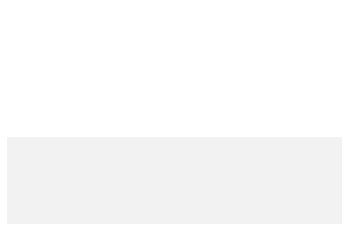

In [65]:
up.add_stacked_bars('Truth', sum_over='Count', elements=6)
print(up._subset_plots)
up._subset_plots.pop(0)
f = plt.figure()
up.plot_shading(plt.axes())

### Normal plot for true/false positives separately

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7feacae80fd0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7feacaaf7240>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7feacad52b70>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7feacac164a8>}

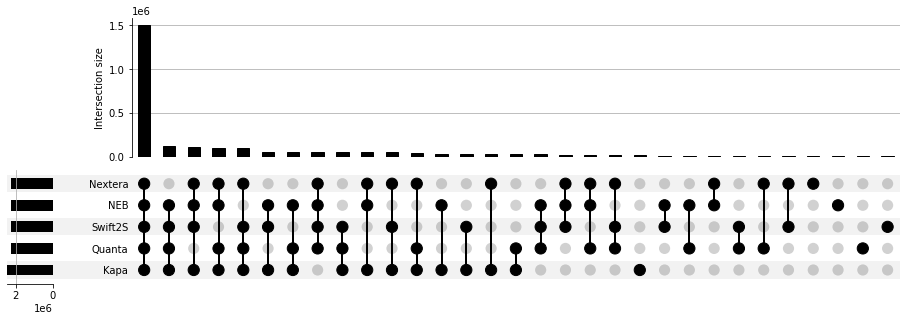

In [68]:
upsetplot.plot(group_combinations[(True,'SNP')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7feac50e9c50>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7feac4ac7320>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7feac516f048>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7feac51acac8>}

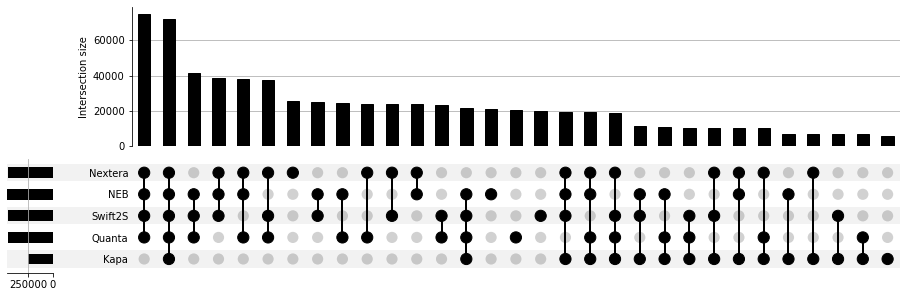

In [15]:
upsetplot.plot(group_combinations[(False,'SNP')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None)

{'matrix': <matplotlib.axes._subplots.AxesSubplot at 0x7feac5291ef0>,
 'shading': <matplotlib.axes._subplots.AxesSubplot at 0x7feac527f710>,
 'totals': <matplotlib.axes._subplots.AxesSubplot at 0x7feac5491a58>,
 'intersections': <matplotlib.axes._subplots.AxesSubplot at 0x7feac54e64e0>}

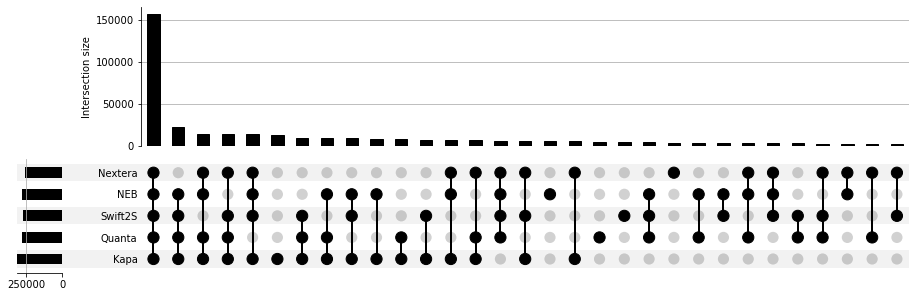

In [16]:
upsetplot.plot(group_combinations[(True, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None)

## Test / experimenting

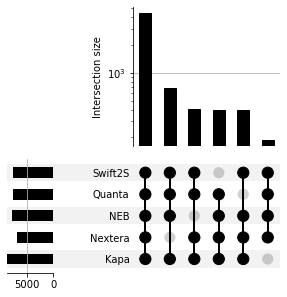

In [15]:
subplots = upsetplot.plot(group_combinations[(True, 'INDEL')].drop(tuple([0]*len(kits))), sort_by='cardinality', sort_categories_by=None, min_degree=4)
subplots['intersections'].set_yscale('log')

In [16]:
intra_kit_consensus

{'Kapa': [231, 1987, 9370, 22901, 53212],
 'Nextera': [1317, 4961, 13332, 22640, 45451],
 'NEB': [1055, 3817, 11577, 21781, 49471],
 'Quanta': [1032, 4349, 12428, 22388, 47504],
 'Swift2S': [1092, 4177, 12361, 22242, 47829]}

In [17]:
kit_numreplicates_trueposcount = [
    (kit, num_replicates_called, intra_kit_consensus[kit][num_replicates_called])
    for num_replicates_called in [0,1,2,3,4]
    for kit in kits
]

In [18]:
iccdf = pd.DataFrame(data=kit_numreplicates_trueposcount, columns=['Kit', 'NumReplicatesHave', 'NumTpCalls'])

<AxesSubplot:xlabel='NumReplicatesHave', ylabel='NumTpCalls'>

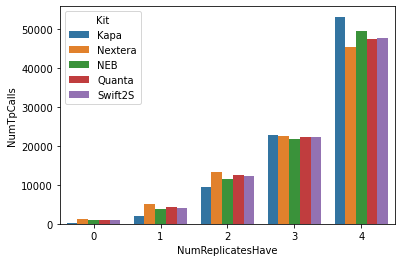

In [19]:
sns.barplot(data=iccdf, x='NumReplicatesHave', y='NumTpCalls', hue='Kit')

## Export data to csv

In [20]:
dataframes = []
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = group_combinations[(truth, typ)].reset_index().rename(columns={0: 'Count'})
    part_df['Truth'] = truth
    part_df['Type'] = typ
    dataframes.append(part_df)
full_df = pd.concat(dataframes)
# Uncomment this to write / overwrite the file
#full_df.to_csv('overlap-variant-data.csv', index=False)
full_df.head(n=1)

,Kapa,Nextera,NEB,Quanta,Swift2S,Count,Truth,Type
0,True,True,True,True,True,42142,True,SNP


# Load exported data

In [11]:
full_df = pd.read_csv('overlap-variant-data.csv')
group_combinations2 = {}
for (truth, typ) in [(True, 'SNP'), (True, 'INDEL'), (False, 'SNP'), (False, 'INDEL')]:
    part_df = full_df.loc[(full_df.Type==typ)&(full_df.Truth==truth)].set_index(kits)
    group_combinations2[(truth, typ)] = part_df.Count

print(group_combinations2[(True, 'SNP')].head(n=1))

Kapa  Quanta  Swift2S  NEB   Nextera
True  True    True     True  True       1508856
Name: Count, dtype: int64


In [12]:
# Uncomment this to load from file 
group_combinations = group_combinations2

# Testing / Experiment

{'matrix': <AxesSubplot:>,
 'shading': <AxesSubplot:>,
 'totals': <AxesSubplot:>,
 'intersections': <AxesSubplot:ylabel='Intersection size'>,
 'extra1': <AxesSubplot:>}

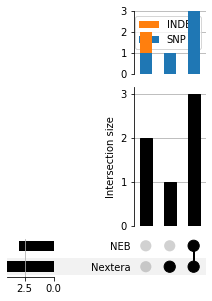

In [23]:
løk = pd.DataFrame(
    {
        #'Kit': ['Nextera', 'NEB', 'Nextera', 'NEB', 'Nextera', 'NEB'],
        'Nextera': [True, True, True, False, False, True],
        'NEB':   [ False, True, True, False, False, True],
        'Type':  ['SNP','SNP','SNP','INDEL','SNP','SNP']
    }
).set_index(['Nextera', 'NEB'])
up = upsetplot.UpSet(løk)
up.add_stacked_bars('Type')
up.plot()

(<Figure size 432x288 with 4 Axes>,
 array([[<AxesSubplot:>, <AxesSubplot:>],
        [<AxesSubplot:>, <AxesSubplot:>]], dtype=object))

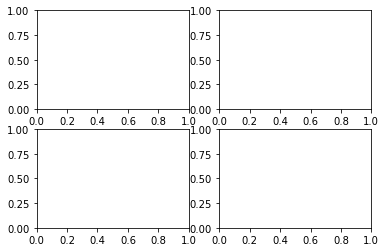

In [24]:
plt.subplots(2, 2)

In [ ]:
(fig, (tops, bots)) = plt.subplots(2, 2)
up2 = upsetplot.UpSet(løk)
up2.plot_matrix(bots[1])
up2.add_stacked_bars('Type')